In [376]:
import pywt
from scipy.io import wavfile
import matplotlib.pyplot as plt
import numpy as np
from numpy import random
import math

In [377]:
n = 100000
num_rec = 2
num_src = 3
BASE_DIR = "C:/Users/Daniel Choi/Desktop/comp-coursework/MATH4992/sources"

x = np.zeros([n,3])
x[:,0] = wavfile.read(f"{BASE_DIR}/bird.wav",n)[1][:n]
x[:,1] = wavfile.read(f"{BASE_DIR}/male.wav",n)[1][:n]
x[:,2] = wavfile.read(f"{BASE_DIR}/female.wav",n)[1][:n]

In [378]:
x/np.tile(np.std(x,0),(n,1))

array([[ 0.00605471,  0.        ,  0.00628191],
       [ 0.01037951,  0.        ,  0.00628191],
       [ 0.00579523, -0.00350931,  0.00628191],
       ...,
       [ 1.14148671,  0.10878849, -0.05967817],
       [-1.48401057,  0.04211167,  0.21986696],
       [-2.19543954,  0.14388155,  0.46172061]])

In [379]:
x = x/np.tile(np.std(x,0),(n,1))

theta = np.linspace(0, np.pi, num_src + 1)[:-1]
theta[0] = .2
M = np.vstack((np.cos(theta), np.sin(theta)))

In [380]:
y = np.dot(x,np.transpose(M))

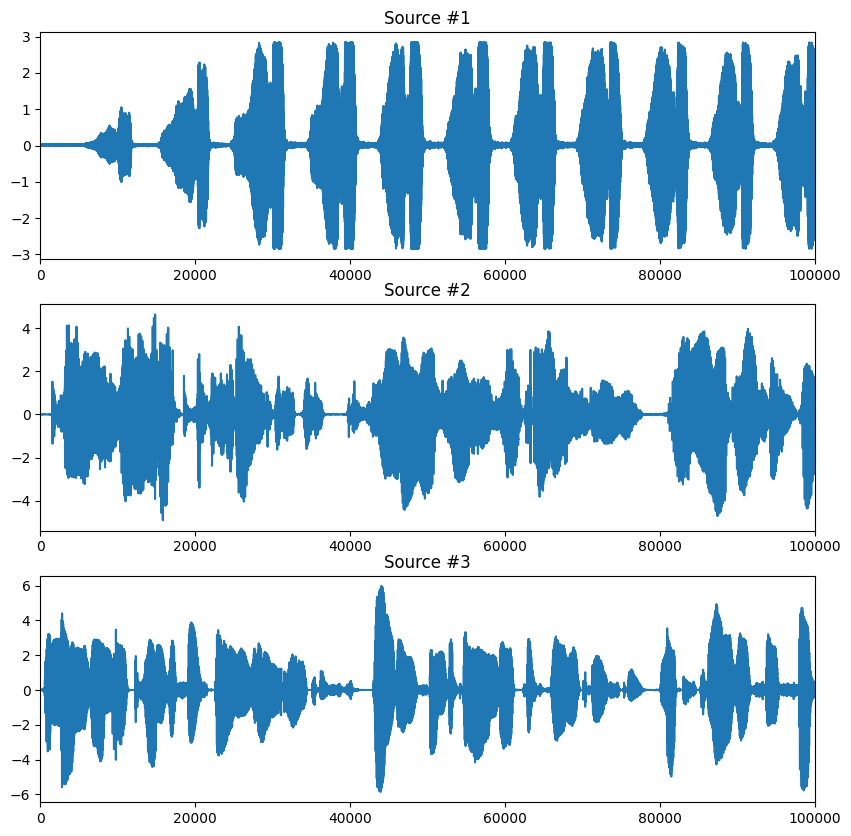

In [381]:
plt.figure(figsize = (10,10))

for i in range(num_src):
    plt.subplot(num_src, 1, i+1)
    plt.plot(x[:, i])
    plt.xlim(0,n)
    plt.title("Source #%i" %(i+1))

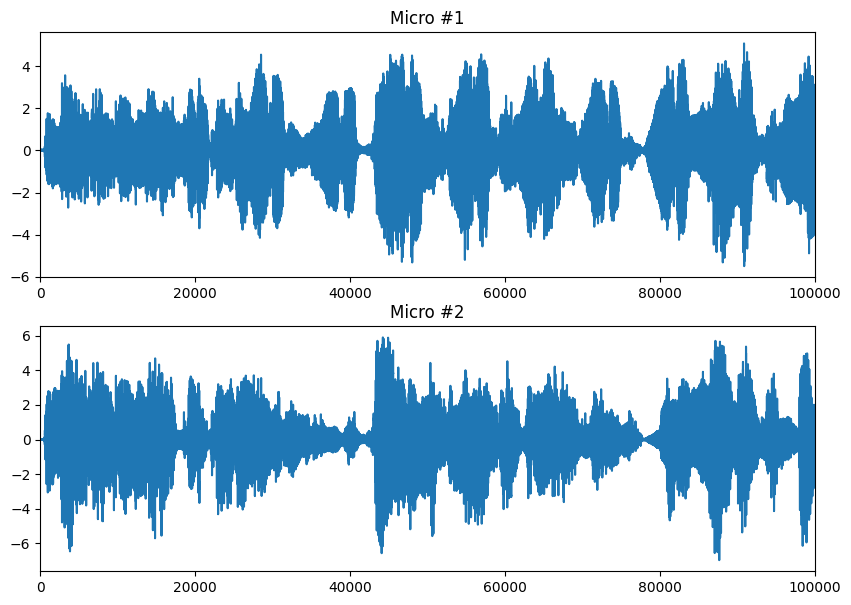

In [382]:
plt.figure(figsize = (10,7))
    
for i in range(num_rec):
    plt.subplot(num_rec, 1, i+1)
    plt.plot(y[:, i])
    plt.xlim(0,n)
    plt.title("Micro #%i" %(i+1))

In [383]:
y.shape

(100000, 2)

In [384]:
wt_level = 4
wavelet = 'haar'
mode = 'symmetric'
coef_a = pywt.wavedec(y[:,0], wavelet=wavelet, level=wt_level, mode=mode)
coef_b = pywt.wavedec(y[:,1], wavelet=wavelet, level=wt_level, mode=mode)

In [385]:
coefs = []

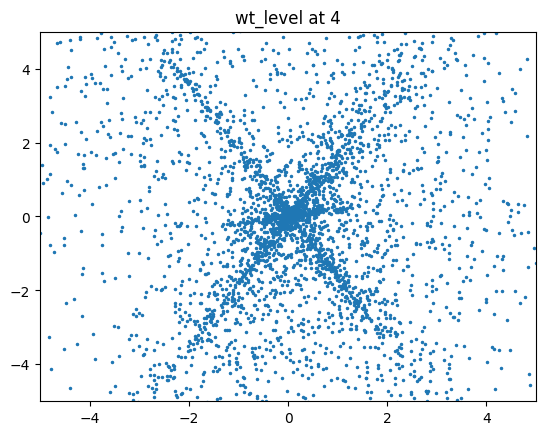

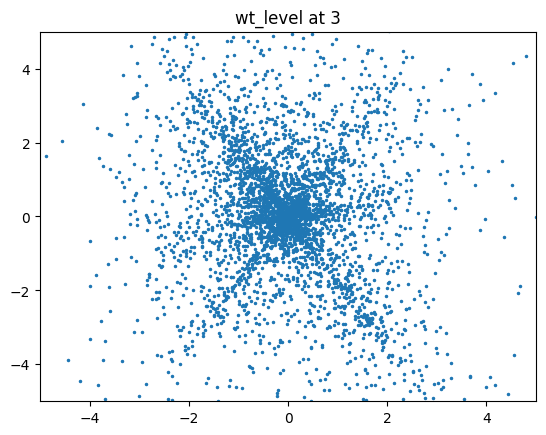

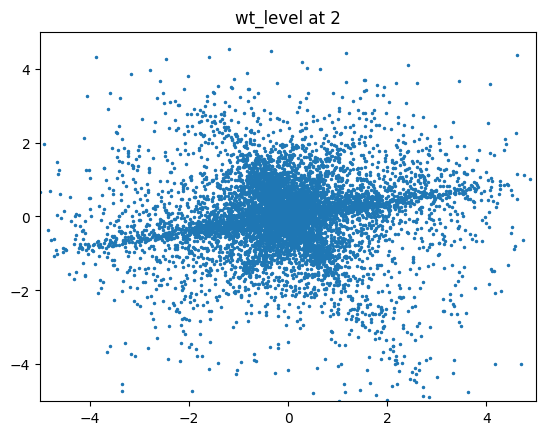

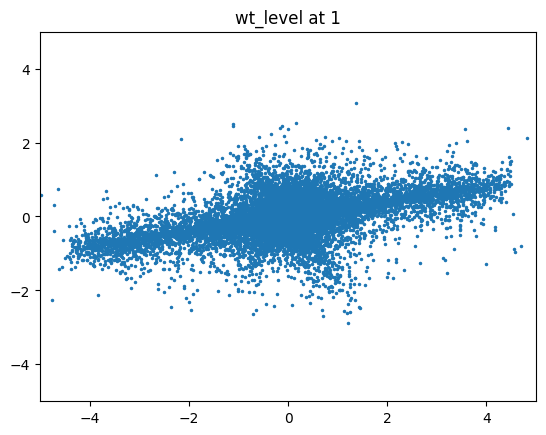

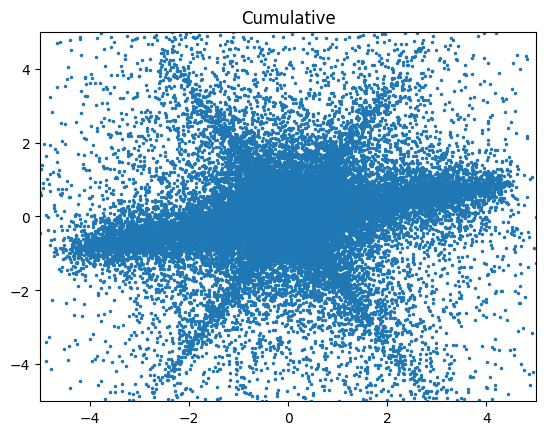

In [386]:
P = False
for target_level in range(0, wt_level):
    # target_level = 1
    wavelet_n = len(coef_a[target_level])
    coef = np.zeros([wavelet_n, 2])
    coef[:,0] = coef_a[target_level]
    coef[:,1] = coef_b[target_level]

    npts = int(wavelet_n*0.7)

    # sel = np.argsort(np.sqrt(y[:,0]**2 + y[:,1]**2))

    sel = random.permutation(npts)
    sel = sel[:npts]

    if type(P) == bool:
        P = coef[:, :]
    else:
        P = np.concatenate((P, coef),axis=0)

    # plt.figure(figsize = (7,5))
    plt.plot(coef[sel,0], coef[sel,1], ".", ms = 3)
    radius = 5
    plt.xlim(-radius,radius)
    plt.ylim(-radius,radius)
    plt.title(f'wt_level at {wt_level-target_level}')

    plt.show()
    
plt.plot(P[:,0], P[:,1], ".", ms = 3)
radius = 5
plt.xlim(-radius,radius)
plt.ylim(-radius,radius)
plt.title(f'Cumulative')

plt.show()

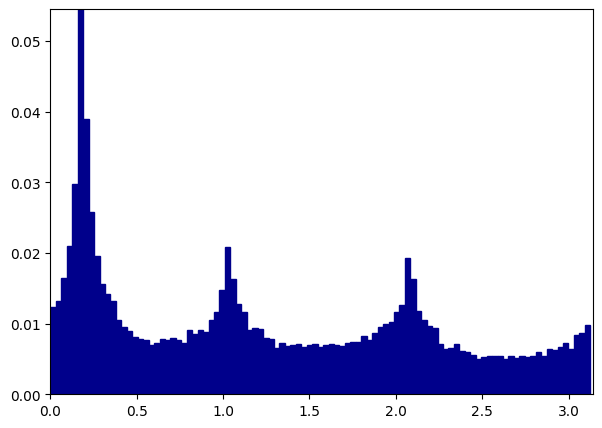

In [387]:
nrow = np.shape(P)[0]
Theta = np.zeros(nrow)
for i in range(nrow):
    Theta[i] = math.atan2(P[i,1],P[i,0])%np.pi
    
nbins = 100
t = np.linspace(np.pi/200,np.pi,nbins)
hist = np.histogram(Theta,t)
h = hist[0]/np.sum(hist[0])
t = t[:-1]

plt.figure(figsize = (7,5))
plt.bar(t, h, width = np.pi/nbins, color = "darkblue", edgecolor = "darkblue")
plt.xlim(0,np.pi)
plt.ylim(0,np.max(h))
plt.show()

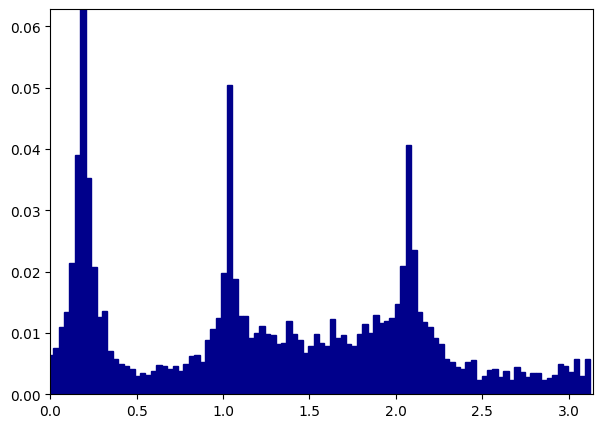

In [388]:
d = np.sum(P**2, 1)
rho = .1
v = np.sort(d)
I = np.argsort(d)[::-1]

#transformed points
I = I[np.arange(1,round(rho*len(I))+1)]
P1 = P[I,:]  
    
#compute Theta
nrow = np.shape(P1)[0]
Theta = np.zeros(nrow)
for i in range(nrow):
    Theta[i] = math.atan2(P1[i,1],P1[i,0])%np.pi

nbins = 100
hist = np.histogram(Theta,nbins)
h = hist[0]/np.sum(hist[0])
t = hist[1][:-1]

plt.figure(figsize = (7,5))
plt.bar(t, h, width = np.pi/nbins, color = "darkblue", edgecolor = "darkblue")
plt.xlim(0,np.pi)
plt.ylim(0,np.max(h))
plt.show()

In [389]:
s1 = np.hstack((np.arange(2,nbins+1),np.array([nbins-1]))) - 1
s2 = np.hstack((np.array([2]),(np.arange(1,nbins)))) - 1
I = np.where((h[s1] < h ) & (h[s2] < h))
v = np.sort(h[I])
u = np.argsort(h[I])[::-1]
theta1 = t[I[0][u[:3]]]
M1 = np.vstack((np.cos(theta1), np.sin(theta1)))
print("--- M ---")
print(M)
print("--- M1 ---")
print(M1)

--- M ---
[[ 0.98006658  0.5        -0.5       ]
 [ 0.19866933  0.8660254   0.8660254 ]]
--- M1 ---
[[ 0.98227116  0.50921483 -0.48126928]
 [ 0.18746566  0.86063945  0.8765728 ]]


In [390]:
np.transpose(M1).shape

(3, 2)

In [391]:
res = []
for i, (a, b) in enumerate(zip(coef_a, coef_b)):
    
    coef = np.zeros([len(a), 2])
    coef[:,0] = a
    coef[:,1] = b
    
    ans = np.dot(np.transpose(M1),np.transpose(coef))
    res.append(ans)
    print(f"index: {i}, shape: {ans.shape}")

index: 0, shape: (3, 6250)
index: 1, shape: (3, 6250)
index: 2, shape: (3, 12500)
index: 3, shape: (3, 25000)
index: 4, shape: (3, 50000)


In [392]:
results = []
for r in res:
    new_r = np.zeros(r.shape)
    new_r[:] = r
    argm = np.argmax(abs(r), axis=0)
    
    for col, v in enumerate(argm):
        for row in range(3):
            mult = 1 if row == v else 0
            new_r[row][col] *= mult
            
    new_r[abs(new_r) < 0.05] = 0
    
    results.append(new_r)
for i in range(3):
    idwt_coef = []
    for r in results:
        idwt_coef.append(r[i])
    idwt_coef
    restored = pywt.waverec(idwt_coef, wavelet=wavelet, mode=mode)
    wavfile.write(f'restored{i}_lvl_{wt_level}.wav', 15000, restored)

In [ ]:
from scipy.io import wavfile
import noisereduce as nr
# load data
rate, data = wavfile.read("mywav.wav")
# perform noise reduction
reduced_noise = nr.reduce_noise(y=data, sr=rate)
wavfile.write("restored1_lvl_4.wav", rate, reduced_noise)

In [393]:
# for i, c in enumerate(coef_a):
#     wavfile.write(f'restored{i}.wav', 15000, c)